# Data Cleaning
This Data cleaning process has been done by thoroughly analyzing the 3 EDA Notebooks and finding patterns or important insights that hint into the necessity of data cleaning.

# Step 0 – Load the Dataset and Inspect Initial Structure

We start by loading the Kaggle Cardiovascular Disease dataset and doing an initial inspection.  
This gives us a baseline to compare all future transformations.  

From our earlier EDA PDFs, we already know:
- The dataset has ~70k rows and 13 columns.
- No missing values initially.
- Data types look consistent but contain clear *outliers* and *encoding issues*.


In [348]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw
df_raw = pd.read_csv("../data/raw/cardio_train.csv", sep=';')

# Working copy
df = df_raw.copy()

print(df_raw.shape)
df_raw.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Step 1 – Remove the ID column and Convert Age from Days to Years

The `id` column is a unique identifier and brings no predictive value — it could even introduce data leakage in models.  
The `age` column is given in **days**, which is not interpretable for medical or statistical analysis.  
We convert it to integer **years**, improving interpretability and comparability with clinical standards.


### Why converting age to integer years makes sense

Using age in whole years instead of days improves interpretability and aligns with how age is commonly recorded and analyzed in real-world datasets, especially for descriptive statistics and visualization. Andrade et al. (2017) explain that treating age in discrete units is often appropriate when the goal is clarity and practical interpretation rather than fine-grained physiological precision.  
Source: [Age as a variable: Continuous or categorical?](https://pmc.ncbi.nlm.nih.gov/articles/PMC5806344/)


We will visualize the age distribution before and after conversion to confirm that the transformation preserves shape.


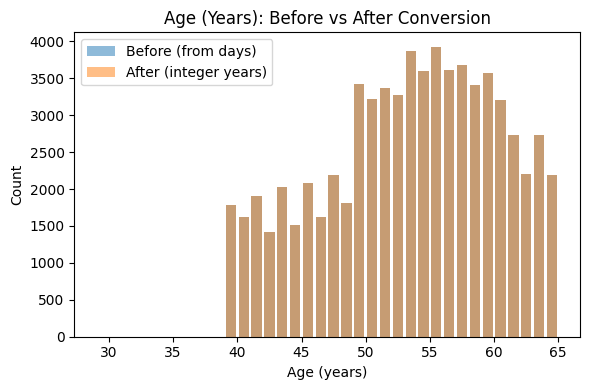

In [349]:
import numpy as np
import matplotlib.pyplot as plt

# Keep a copy before transformation
df_step0 = df.copy()

# Convert
if 'id' in df.columns:
    df = df.drop(columns=['id'])
df['age_years'] = (df['age'] / 365).astype(int)
df = df.drop(columns=['age'])

# Use integer bins for consistent visualization
bins = np.arange(29, 66, 1)

# -----------------------------
# COMBINED BEFORE vs AFTER PLOT
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(df_step0['age'] / 365, bins=bins, alpha=0.5, rwidth=0.8, label="Before (from days)")
ax.hist(df['age_years'], bins=bins, alpha=0.5, rwidth=0.8, label="After (integer years)")

ax.set_title("Age (Years): Before vs After Conversion")
ax.set_xlabel("Age (years)")
ax.set_ylabel("Count")
ax.legend()

plt.tight_layout()
plt.show()

This plot shows the effect of converting age from days to integer years. The “before” and “after” histograms almost perfectly overlap, meaning the conversion did not change the overall age distribution. The vertical bars represent exact counts per integer age after discretization. This confirms that only rounding was applied without distorting the data.


# Step 2 – Clean Height, Weight, and Calculate BMI

From our EDA, we noticed biologically impossible values:
- Heights as low as 55 cm and above 250 cm
- Weights under 30 kg or above 200 kg  

Such entries distort statistics and model relationships.

We first remove rows from height and weight violating realistic adult threshhold:
- `140 ≤ height ≤ 210`
- `30 ≤ weight ≤ 200`

## BMI

Body Mass Index (BMI) is a widely used indicator to assess body weight relative to height and to identify underweight, overweight, and obesity at the population level. Cleaning height and weight before computing BMI, and removing implausible BMI values afterward, improves data validity and prevents extreme measurement errors from distorting analyses.  
Source: [World Health Organization – BMI Classification](https://www.who.int/data/gho/data/themes/theme-details/GHO/body-mass-index-(bmi))


We compute the **Body Mass Index (BMI)** as 
`Weight / (Height / 100) ^ 2`

Then we remove unrealisticly values from BMI
- `15 ≤ BMI ≤ 60`

These limits capture the full adult physiological range while discarding clearly corrupted entries.

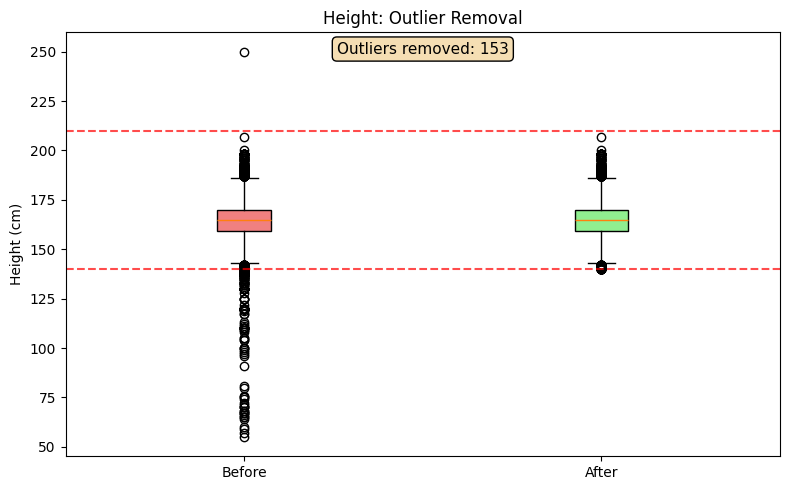

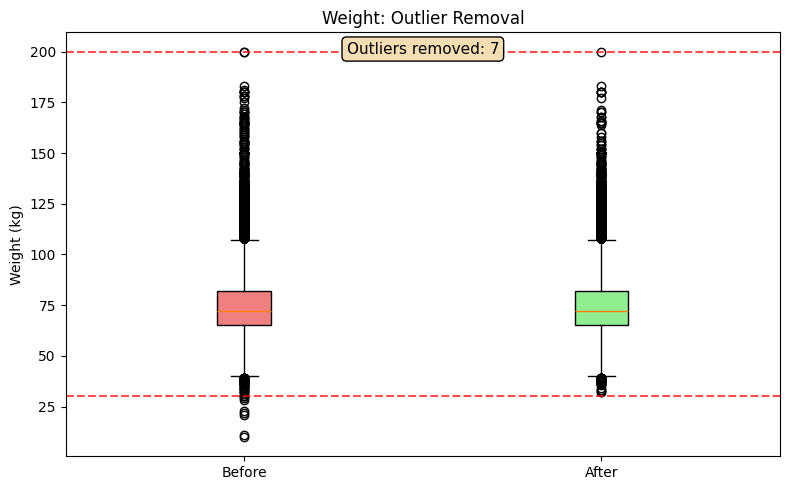

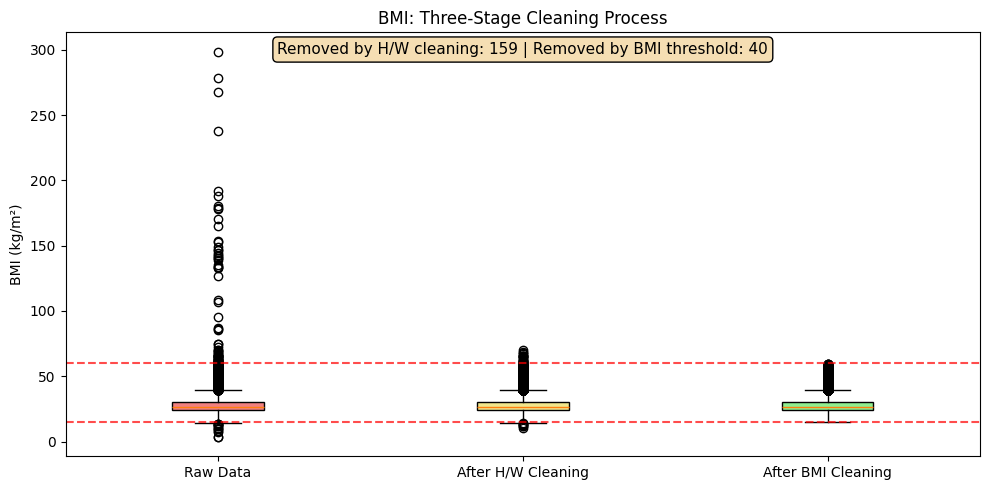

STEP 2 SUMMARY
Rows before: 70,000
Rows after:  69,801
Total rows removed: 199
Percentage removed: 0.28%

Columns before: 12
Columns after:  13
New column added: BMI


In [350]:

# -----------------------------
# STEP 1: Keep original copy
# -----------------------------
df_step1 = df.copy()
df_step1_untouched = df_step1.copy()

# Compute BMI on raw data
df_step1['BMI'] = df_step1['weight'] / (df_step1['height'] / 100) ** 2

# -----------------------------
# CLEAN HEIGHT & WEIGHT FIRST
# -----------------------------
mask_hw = (
    df['height'].between(140, 210) &
    df['weight'].between(30, 200)
)
df_hw = df[mask_hw].copy()

# Compute BMI after height & weight cleaning
df_hw['BMI'] = df_hw['weight'] / (df_hw['height'] / 100) ** 2

# -----------------------------
# CLEAN BMI
# -----------------------------
mask_bmi = df_hw['BMI'].between(15, 60)
df = df_hw[mask_bmi].copy()


# 1. HEIGHT
fig, ax = plt.subplots(figsize=(8, 5))
height_data = [df_step1['height'], df['height']]
bp1 = ax.boxplot(height_data, tick_labels=['Before', 'After'], patch_artist=True)
bp1['boxes'][0].set_facecolor('lightcoral')
bp1['boxes'][1].set_facecolor('lightgreen')
ax.set_ylabel('Height (cm)')
ax.set_title('Height: Outlier Removal')
ax.axhline(y=140, color='red', linestyle='--', alpha=0.7, label='Threshold (140-210 cm)')
ax.axhline(y=210, color='red', linestyle='--', alpha=0.7)

height_outliers = ((df_step1['height'] < 140) | (df_step1['height'] > 210)).sum()
ax.text(0.5, 0.95, f'Outliers removed: {height_outliers}', 
        transform=ax.transAxes, ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# 2. WEIGHT
fig, ax = plt.subplots(figsize=(8, 5))
weight_data = [df_step1['weight'], df['weight']]
bp2 = ax.boxplot(weight_data, tick_labels=['Before', 'After'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightcoral')
bp2['boxes'][1].set_facecolor('lightgreen')
ax.set_ylabel('Weight (kg)')
ax.set_title('Weight: Outlier Removal')
ax.axhline(y=30, color='red', linestyle='--', alpha=0.7)
ax.axhline(y=200, color='red', linestyle='--', alpha=0.7)

weight_outliers = ((df_step1['weight'] < 30) | (df_step1['weight'] > 200)).sum()
ax.text(0.5, 0.95, f'Outliers removed: {weight_outliers}', 
        transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# 3. BMI - Three stages: Raw → After H/W cleaning → After BMI cleaning
fig, ax = plt.subplots(figsize=(10, 5))
bmi_data = [df_step1['BMI'], df_hw['BMI'], df['BMI']]
bp3 = ax.boxplot(bmi_data, tick_labels=['Raw Data', 'After H/W Cleaning', 'After BMI Cleaning'], patch_artist=True)
bp3['boxes'][0].set_facecolor('lightcoral')
bp3['boxes'][1].set_facecolor('khaki')
bp3['boxes'][2].set_facecolor('lightgreen')
ax.set_ylabel('BMI (kg/m²)')
ax.set_title('BMI: Three-Stage Cleaning Process')
ax.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='BMI Threshold (15-60)')
ax.axhline(y=60, color='red', linestyle='--', alpha=0.7)

# Count outliers at each stage
bmi_outliers_from_hw = len(df_step1) - len(df_hw)
bmi_outliers_from_bmi = ((df_hw['BMI'] < 15) | (df_hw['BMI'] > 60)).sum()
ax.text(0.5, 0.95, f'Removed by H/W cleaning: {bmi_outliers_from_hw} | Removed by BMI threshold: {bmi_outliers_from_bmi}', 
        transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

# -----------------------------
# STEP SUMMARY
# -----------------------------
print("="*50)
print("STEP 2 SUMMARY")
print("="*50)
print(f"Rows before: {df_step1_untouched.shape[0]:,}")
print(f"Rows after:  {df.shape[0]:,}")
print(f"Total rows removed: {df_step1_untouched.shape[0] - df.shape[0]:,}")
print(f"Percentage removed: {(df_step1_untouched.shape[0] - df.shape[0]) / df_step1_untouched.shape[0] * 100:.2f}%")
print(f"\nColumns before: {df_step1_untouched.shape[1]}")
print(f"Columns after:  {df.shape[1]}")
print("New column added: BMI")

The boxplots above visualize the outlier removal process for height, weight, and BMI:

**Height:** 153 outliers were removed (values below 140 cm or above 210 cm). The "After" boxplot shows a tighter distribution within the realistic adult height range.

**Weight:** Only 7 outliers were removed (values below 30 kg or above 200 kg). Most weight values were already within realistic bounds.

**BMI (Three-Stage Process):**
- The "Raw Data" boxplot shows extreme BMI values (up to ~300 kg/m²) caused by implausible height/weight combinations.
- After height/weight cleaning, 159 rows were removed, significantly reducing extreme BMI outliers.
- After applying the BMI threshold (15–60 kg/m²), an additional 40 rows were removed.

Overall, the cleaning process removes measurement errors while preserving the core distribution of each variable.

# Step 3 – Clean and Validate Blood Pressure Data

Blood pressure values (`ap_hi`, `ap_lo`) contained clear errors in our EDA:
- Negative and extreme values  
- Cases where `ap_lo > ap_hi`, likely swapped entries  

We fix these by:
1. Keeping only realistic ranges  
   (`80 ≤ ap_hi ≤ 250`, `40 ≤ ap_lo ≤ 200`)
2. Swapping values when `ap_lo > ap_hi`
3. Adding **pulse pressure (`pp`)** = `ap_hi - ap_lo`

Pulse pressure helps us **check validity** (it should stay within 10–150 mmHg)  
and is also **clinically relevant**, as higher PP often signals greater cardiovascular risk.

After cleaning, we verify the distributions of systolic and diastolic pressures to ensure they look realistic.


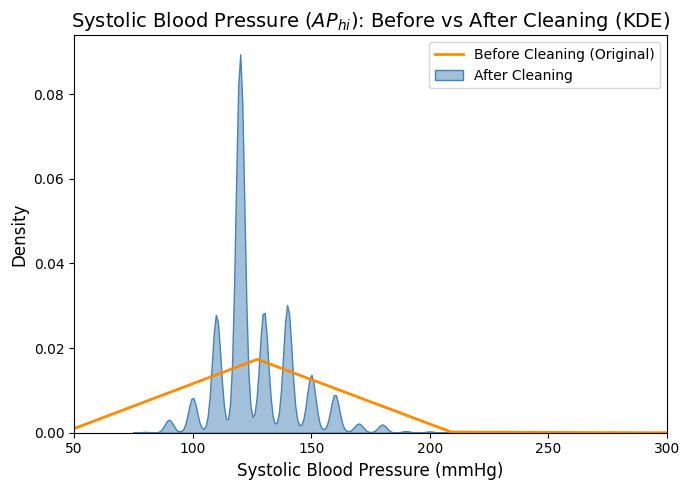

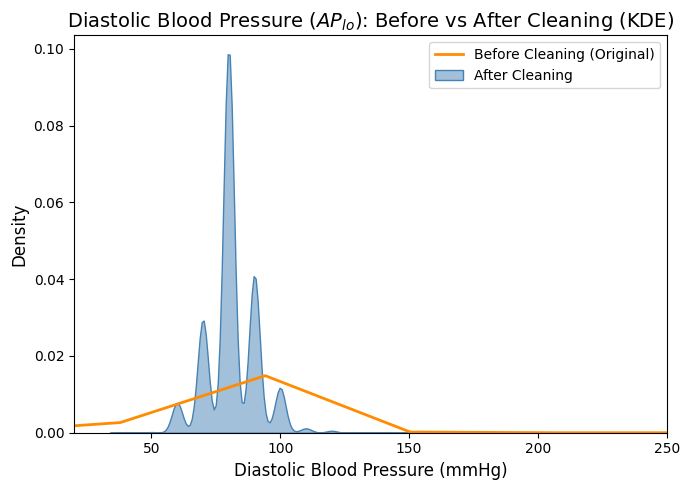

Rows removed in cleaning steps: 1327


In [351]:

import seaborn as sns

# NOTE: Assuming 'df' is your loaded DataFrame

# ====================================================
# 1. CLEANING LOGIC
# ====================================================

df_step2 = df.copy()

# Keep realistic ranges
df = df[df['ap_hi'].between(80, 250)]
df = df[df['ap_lo'].between(40, 200)]

# Remove impossible ordering (ap_lo must be < ap_hi)
df = df[df['ap_lo'] < df['ap_hi']]

# Add pulse pressure
df['pp'] = df['ap_hi'] - df['ap_lo']

# Keep realistic pulse pressure (typically between 10 and 150)
df = df[df['pp'].between(10, 150)]

# ====================================================
# 2. SEABORN KDE COMPARISON DIAGRAMS
# ====================================================

# SYSTOLIC COMPARISON using KDE
fig, ax = plt.subplots(figsize=(7, 5))

# Plot KDE for "Before" and "After"
sns.kdeplot(df_step2['ap_hi'], ax=ax, label="Before Cleaning (Original)", linewidth=2, color='darkorange')
sns.kdeplot(df['ap_hi'], ax=ax, label="After Cleaning", fill=True, alpha=0.5, color='steelblue')

ax.set_xlim(50, 300)
ax.set_title("Systolic Blood Pressure ($AP_{hi}$): Before vs After Cleaning (KDE)", fontsize=14)
ax.set_xlabel("Systolic Blood Pressure (mmHg)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()
# DIASTOLIC COMPARISON using KDE (FIXED)
fig, ax = plt.subplots(figsize=(7, 5))

# 1. Plot Before (Original)
sns.kdeplot(df_step2['ap_lo'], ax=ax, label="Before Cleaning (Original)", linewidth=2, color='darkorange')

# 2. Plot After (with adjusted bandwidth)
# Try setting bw_adjust to 2.0 or 3.0 (2.0 is a good starting point for smoothing)
sns.kdeplot(df['ap_lo'], ax=ax, label="After Cleaning", fill=True, alpha=0.5, color='steelblue', bw_adjust=2.0)

ax.set_xlim(20, 250)
ax.set_title("Diastolic Blood Pressure ($AP_{lo}$): Before vs After Cleaning (KDE)", fontsize=14)
ax.set_xlabel("Diastolic Blood Pressure (mmHg)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# ====================================================
# 3. ROW REMOVAL SUMMARY
# ====================================================
print("Rows removed in cleaning steps:", df_step2.shape[0] - df.shape[0])

# Step 4 – Validate and Restrict Categorical Values

Several columns must strictly adhere to limited categorical sets.
This step ensures internal consistency and prevents model confusion caused by unexpected labels.

Expected domains:
- `gender ∈ {1, 2}`
- `cholesterol ∈ {1, 2, 3}`
- `gluc ∈ {1, 2, 3}`
- `smoke, alco, active, cardio ∈ {0, 1}`

We verify these, remove invalid entries if found, and visualize one example to confirm.

Invalid values before filtering:
gender: 0
cholesterol: 0
gluc: 0
smoke: 0
alco: 0
active: 0
cardio: 0
Rows removed in Step 4: 0


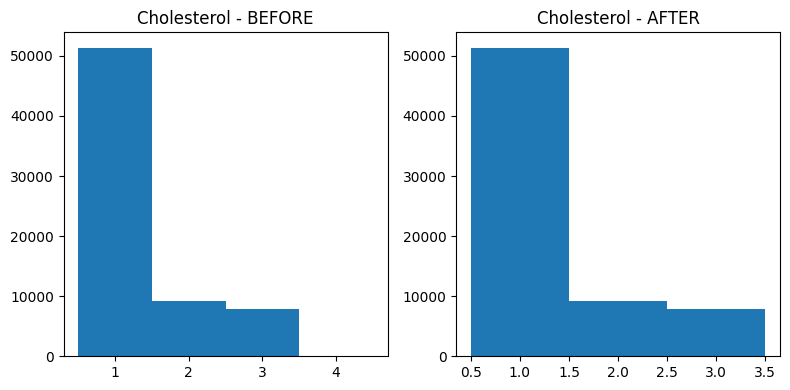

In [352]:
df_step3 = df.copy()

# Count invalids BEFORE
print("Invalid values before filtering:")
print("gender:", (~df_step3['gender'].isin([1, 2])).sum())
print("cholesterol:", (~df_step3['cholesterol'].isin([1, 2, 3])).sum())
print("gluc:", (~df_step3['gluc'].isin([1, 2, 3])).sum())
for col in ['smoke', 'alco', 'active', 'cardio']:
    print(f"{col}:", (~df_step3[col].isin([0, 1])).sum())

# Apply filters
df = df[df['gender'].isin([1, 2])]
df = df[df['cholesterol'].isin([1, 2, 3])]
df = df[df['gluc'].isin([1, 2, 3])]
for col in ['smoke', 'alco', 'active', 'cardio']:
    df = df[df[col].isin([0, 1])]

print("Rows removed in Step 4:", df_step3.shape[0] - df.shape[0])

# Example plot: Cholesterol distribution before/after
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist(df_step3['cholesterol'], bins=[0.5,1.5,2.5,3.5,4.5])
axes[0].set_title("Cholesterol - BEFORE")
axes[1].hist(df['cholesterol'], bins=[0.5,1.5,2.5,3.5])
axes[1].set_title("Cholesterol - AFTER")
plt.tight_layout()
plt.show()


# Step 5 – Post-Cleaning Sanity Checks

Now that we’ve removed corrupted entries and standardized categories,  
we need to verify that our dataset integrity and balance are preserved.

We’ll:
1. Confirm class balance (cardio 0/1)
2. Re-examine correlations of continuous variables with `cardio`
3. Compare BMI distributions before and after cleaning

Final dataset shape: (68474, 14)
Class balance (cardio):
cardio
0    0.505155
1    0.494845
Name: proportion, dtype: float64
cardio       1.000000
ap_hi        0.428123
ap_lo        0.340008
pp           0.337074
age_years    0.239315
BMI          0.192938
weight       0.180944
height      -0.012618
Name: cardio, dtype: float64


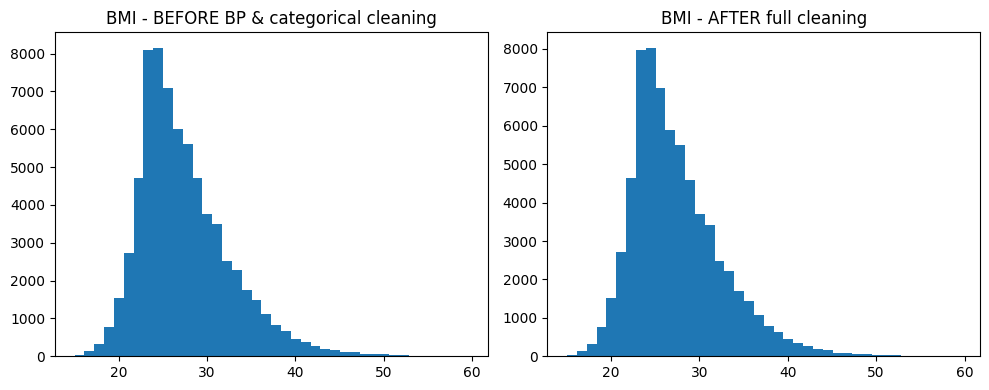

In [353]:
print("Final dataset shape:", df.shape)
print("Class balance (cardio):")
print(df['cardio'].value_counts(normalize=True))

num_cols = ['age_years', 'height', 'weight', 'BMI', 'ap_hi', 'ap_lo', 'pp']
corrs = df[num_cols + ['cardio']].corr()['cardio'].sort_values(ascending=False)
print(corrs)

# Compare BMI before and after full cleaning
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_step2['BMI'], bins=40)
axes[0].set_title("BMI - BEFORE BP & categorical cleaning")
axes[1].hist(df['BMI'], bins=40)
axes[1].set_title("BMI - AFTER full cleaning")
plt.tight_layout()
plt.show()


# New Correlation Matrix

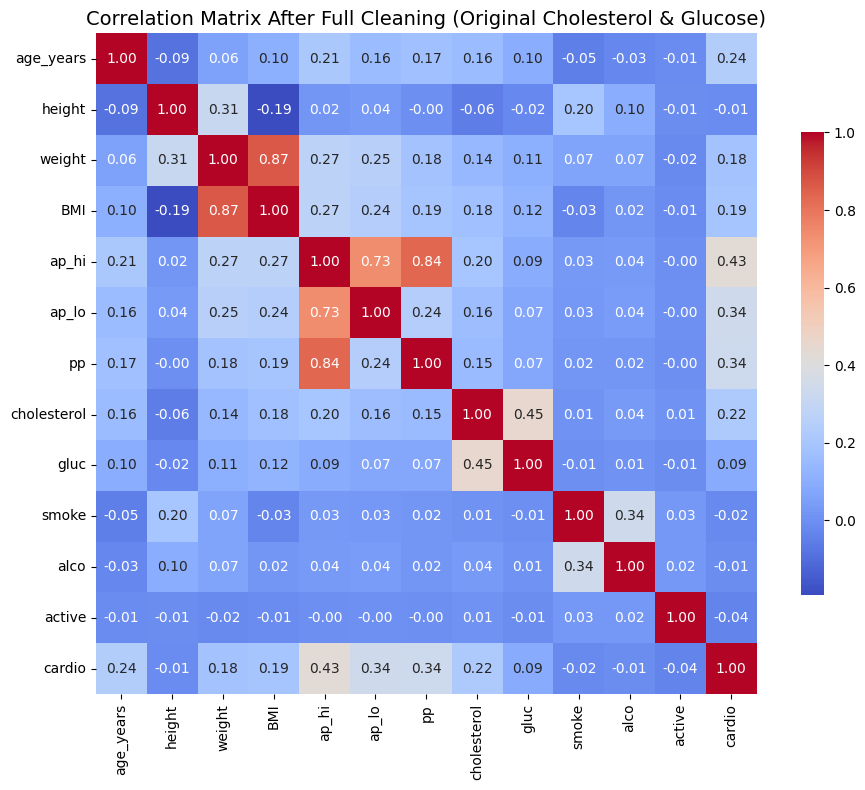


Top correlations with cardio:

cardio         1.000000
ap_hi          0.428123
ap_lo          0.340008
pp             0.337074
age_years      0.239315
cholesterol    0.221349
BMI            0.192938
weight         0.180944
gluc           0.089158
alco          -0.008465
height        -0.012618
smoke         -0.016227
active        -0.037808
Name: cardio, dtype: float64


In [354]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features 
corr_features = [
    'age_years', 'height', 'weight', 'BMI',
    'ap_hi', 'ap_lo', 'pp',
    'cholesterol', 'gluc',
    'smoke', 'alco', 'active', 'cardio'
]

# Compute correlation matrix
corr_matrix = df[corr_features].corr()

# Plot correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Matrix After Full Cleaning (Original Cholesterol & Glucose)", fontsize=14)
plt.tight_layout()
plt.show()

# Print top correlations with cardio
print("\nTop correlations with cardio:\n")
print(corr_matrix['cardio'].sort_values(ascending=False))


We export the new cleaned data to a csv file.

In [355]:
# Define filename for cleaned dataset
clean_filename = "../data/clean/cardio_cleaned.csv"

# Export cleaned dataframe
df.to_csv(clean_filename, sep=';', index=False)
